# Old Notebook was getting far too slow

In [1]:
import sys
sys.path.append('..')
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [2]:
# Wish to create a version of the SFT function that runs between two multiples of the effective radius

# After this we can create a set of annuli of a defined width to loop over the image

def Spiral_Power_spec_annulus(Image,Table,n1,n2,m,byte_order=False):
    
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate teh Annuli radii
    R_min = n1*R_e
    R_max = n2*R_e
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(np.log10(R_min))
    lnr_max = float(np.log10(R_max))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    if byte_order == True:
        img = img.byteswap().newbyteorder('L')
    else:
        img = img
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    A_p_m = 1/D *(img_lnr_theta * weight).sum((-1, -2))
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan((0-m)/p_max))
    #print('Winding angle \u03C6 =', phi)
    
    # Calculate signal to noise 
    SN_m, SN_w = gfits.SN(A)
    
    return A, A_p_m, p, SN_w, p_max, SN_m, phi


In [3]:
# Test it over the range 0.3 - 0.7 on M51_B as we know it should be 19.3

M_51_B       = gfits.Read('/home/borge/Data/Case_studies/HST/M51/m51_optical_B.fits')
M_51_B_Table = gfits.Read_Table('/home/borge/Data/Case_studies/HST/M51/m51_optical_B/0200/source_params.fits')

In [4]:
n_i = 0.3
n_o = 0.95

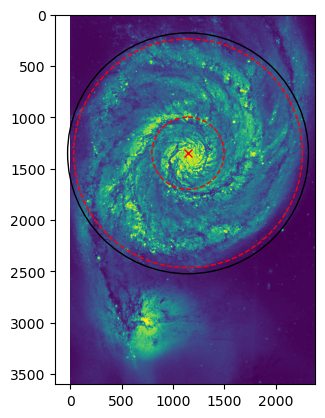

In [5]:
gfits.Overlay_table_info(M_51_B,M_51_B_Table,n_i,n_o)

In [6]:
A, A_p_m, p, SN_w, p_max, SN_m, phi = Spiral_Power_spec_annulus(M_51_B,M_51_B_Table,n_i,n_o,2,byte_order=True)

In [7]:
phi

-61.189206257018796

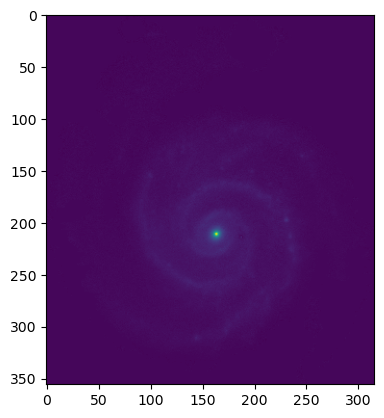

In [8]:
R_2857_O = gfits.Read('/home/borge/Data/Test_batch/587732050555961424ra.fits.gz')
R_2857_I = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/small_nonpar.fits')
R_2857_T = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/source_params.fits')
plt.imshow(R_2857_O)


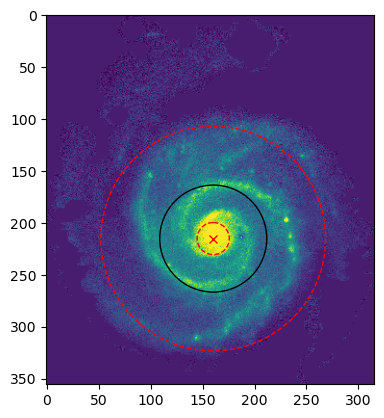

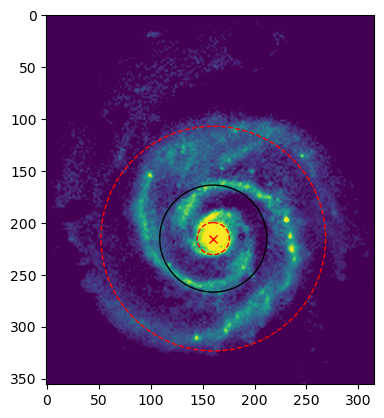

In [9]:
gfits.Overlay_table_info(R_2857_O,R_2857_T,0.3,2.1)
gfits.Overlay_table_info(R_2857_I,R_2857_T,0.3,2.1)

2

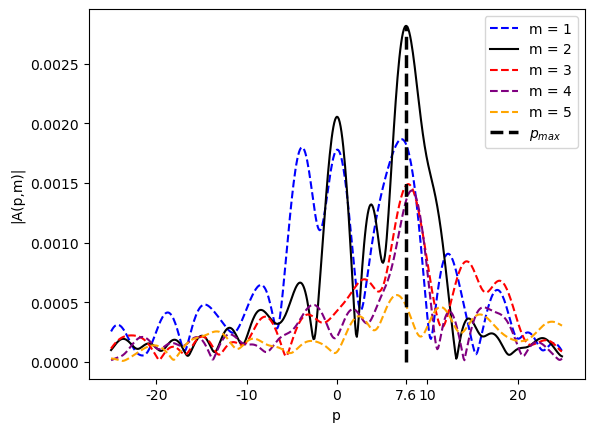

In [10]:
gfits.Number_of_arms(R_2857_O,R_2857_T,0.3,True,False)

(1, 1) [160]
(1, 1) [160]
Winding angle φ = -14.743562836469874  Pattern position angle θ =  12.392565209011696


(-14.743562836469874, 0.21629106566535336)

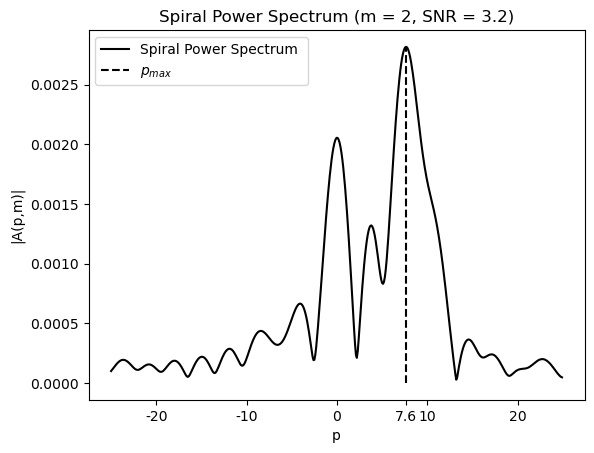

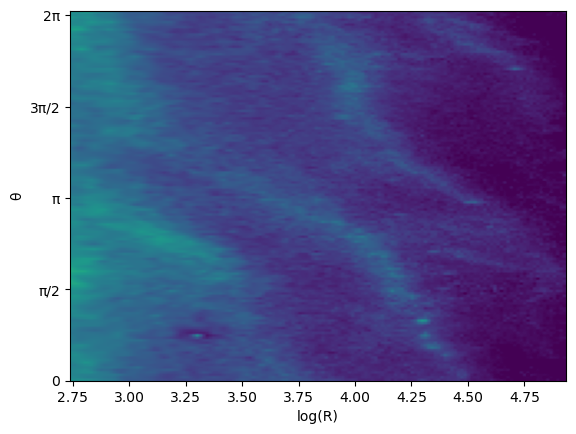

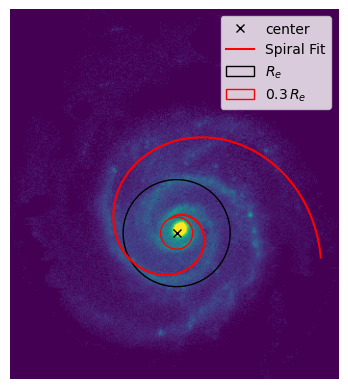

In [13]:
gfits.Spiral_Fourier_Transform(R_2857_O,R_2857_T,0.3,2,True,False)